In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


In [60]:
%%writefile going_modular/pred_and_plot_image.py

from typing import List, Tuple

from PIL import Image

from torchvision import transforms 

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (244, 244),
                        transform: torchvision.transforms = None, 
                        device: torch.device=device):
    
    img = Image.open(image_path)
    
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
                                        transforms.Resize(image_size),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
    ])
        
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        
        target_image_pred = model(transformed_image.to(device))
        
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    plt.figure()
    plt.imshow(img) 
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f} | Correct: {image_path.parent.stem}")
    plt.axis(False)

Writing going_modular/pred_and_plot_image.py


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary
    
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
    

C:\Users\vilem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vilem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\cuda\__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                        destination="pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [5]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x22376180400>,
 ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

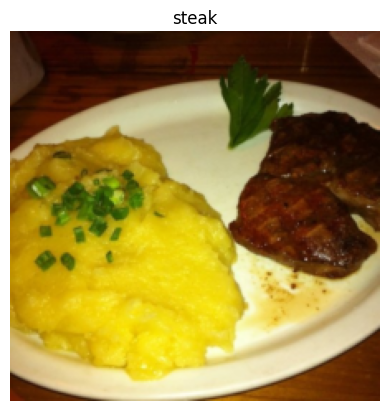

In [8]:
plt.imshow(image.permute(1, 2, 0)) 
plt.title(class_names[label])
plt.axis(False)

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 


* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16 

number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


torch.Size([3, 224, 224])

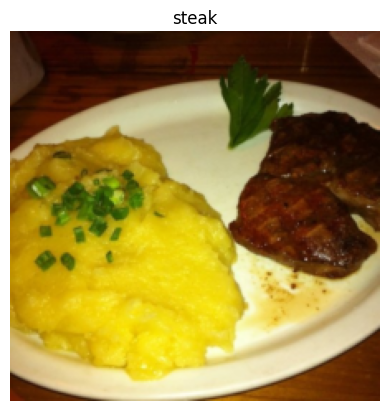

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
image.shape

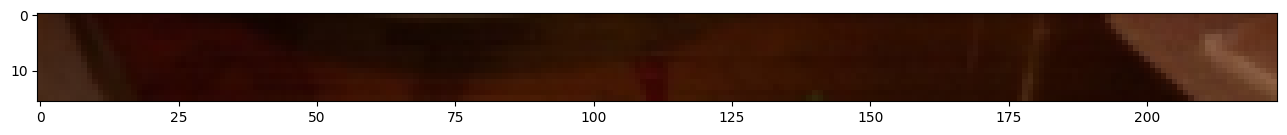

In [12]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


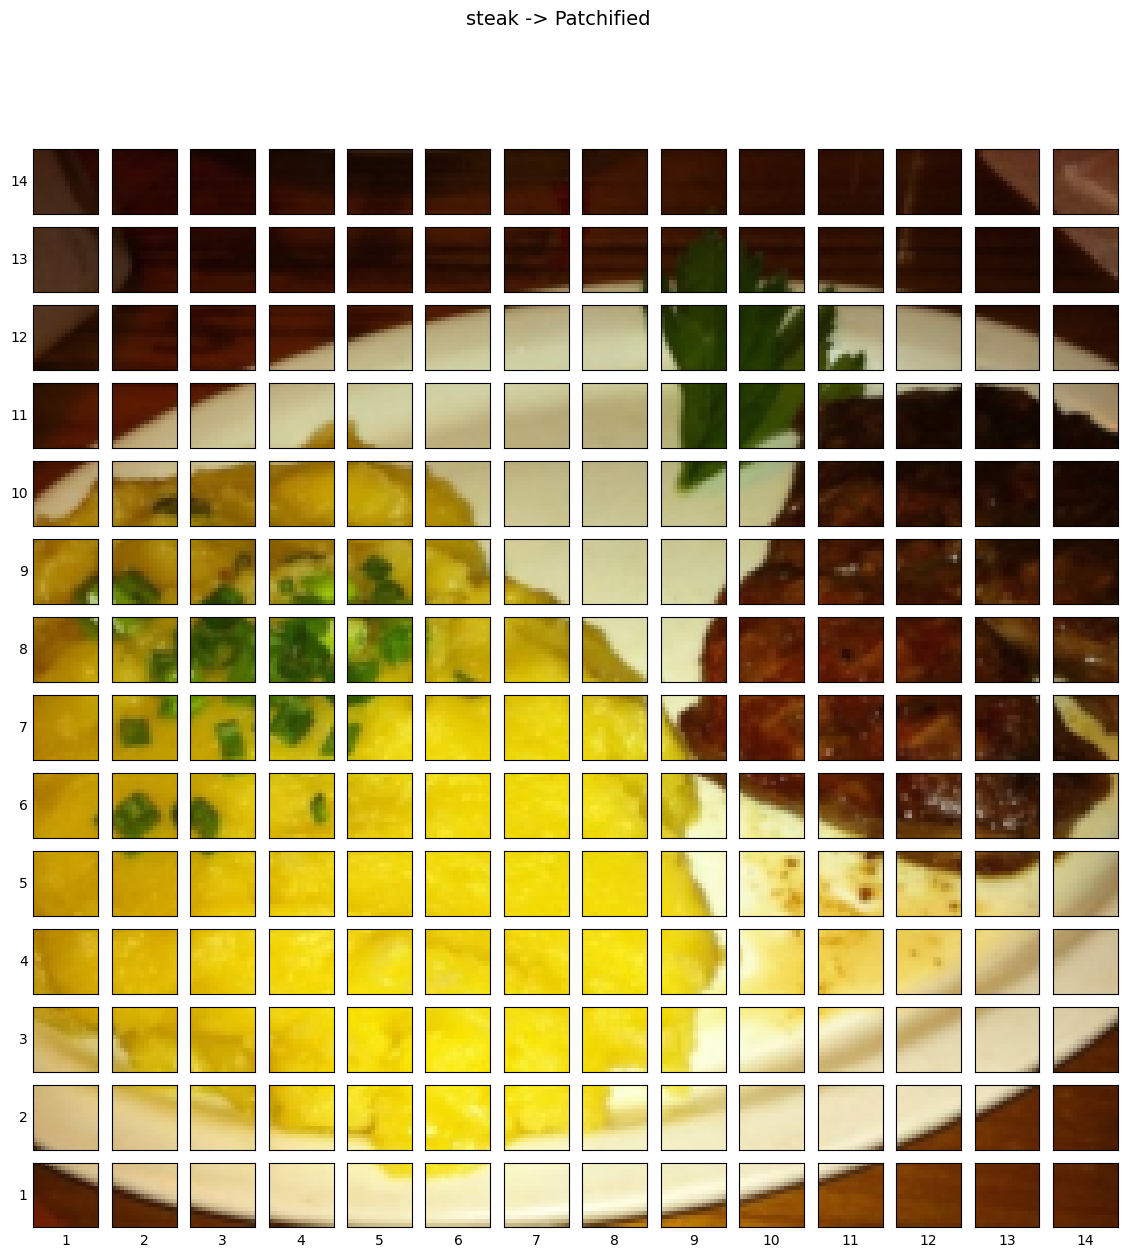

In [13]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)


for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on the different axes 
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        # Set up label information for each subplot (patch)
        axs[i, j].set_ylabel(img_size // patch_size - i,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


In [14]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                    out_channels=768, 
                    kernel_size=patch_size,
                    stride=patch_size,
                    padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [15]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape), image.shape

torch.Size([1, 768, 14, 14])


(None, torch.Size([3, 224, 224]))

Showing random convolutional feature maps from indexes: [389, 534, 501, 535, 221]


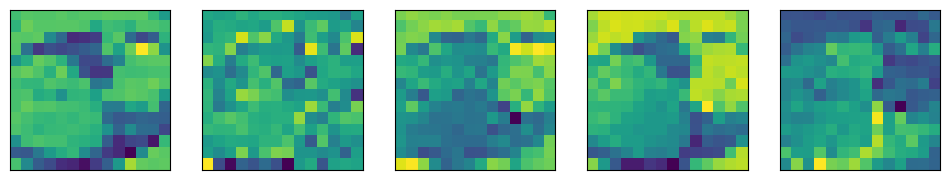

In [16]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] 
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) 
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [17]:
single_feature_map = image_out_of_conv[:, 0, :, :] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.1776,  0.1445,  0.1229,  0.1507,  0.1304,  0.1998,  0.1855,
            0.2149,  0.1814,  0.1597,  0.1687,  0.1169,  0.3508,  0.4311],
          [ 0.3103,  0.1016,  0.1355,  0.1640,  0.1644,  0.1990,  0.2316,
            0.3406,  0.1942,  0.2589,  0.2328,  0.1001,  0.1261,  0.4011],
          [ 0.1262,  0.2329,  0.2448,  0.5564,  1.0875,  1.0221,  1.1339,
            1.1262,  0.1323,  0.1717,  1.0464,  0.8912,  0.5671,  0.3920],
          [ 0.2820,  0.8088,  1.0837,  1.0692,  1.1451,  1.0795,  1.0428,
            1.0317,  0.0108,  0.4021,  0.2215,  0.2271,  0.2408,  0.5030],
          [ 0.8744,  0.6273,  0.6237,  0.6862,  0.6546,  1.0133,  1.1178,
            1.1155,  0.9143,  0.4570,  0.2130,  0.1536,  0.1340,  0.1058],
          [ 0.5881,  0.5343,  0.3764,  0.5859,  0.5867,  0.7186,  1.0544,
            1.2186,  1.1300, -0.0573,  0.2634,  0.2284,  0.2024,  0.1370],
          [ 0.6231,  0.5962,  0.3728,  0.3536,  0.3682,  0.7129,  0.7033,
            1.1540,  0.6426,  0.

In [18]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


In [19]:
from torch import nn

flatten_layer = nn.Flatten(start_dim=2,
                            end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


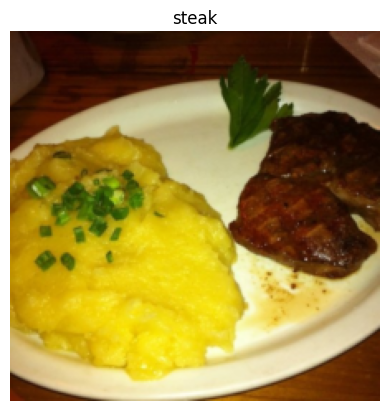

In [20]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [21]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 768, 196]) -> (batch_size, number_of_patches, embedding_dimension)


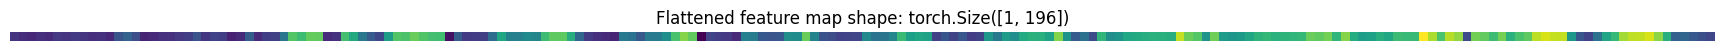

In [22]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False); 

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `foward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [23]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                    in_channels: int=3,
                    patch_size: int=16,
                    embedding_dim:int=768):
        super().__init__()
        
        self.patch_size = patch_size
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                    end_dim=3)
        
    def forward(self, x):
        
        image_resolution = x.shape[-1]
        
        assert image_resolution % patch_size == 0,  f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        x_patched = self.patcher(x)
        
        x_flattened = self.flatten(x_patched)
        
        return x_flattened.permute(0, 2, 1)

In [24]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                            patch_size=16,
                            embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [25]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

In [26]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                            requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [27]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                    dim=1) # number_of_patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1299, -0.0256, -0.0854,  ...,  0.0536, -0.0718,  0.1230],
         [-0.1234, -0.0246, -0.0126,  ...,  0.0285, -0.0465,  0.0511],
         ...,
         [-0.3012, -0.0074, -0.0266,  ...,  0.1408, -0.1752,  0.1576],
         [-0.2511, -0.0275, -0.0326,  ...,  0.1104, -0.1426,  0.1212],
         [-0.2241, -0.0204, -0.0340,  ...,  0.0934, -0.1145,  0.1263]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


In [28]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [29]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1,
                                                number_of_patches+1,
                                                embedding_dimension),
                                requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [30]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8701, 0.9744, 0.9146,  ..., 1.0536, 0.9282, 1.1230],
         [0.8766, 0.9754, 0.9874,  ..., 1.0285, 0.9535, 1.0511],
         ...,
         [0.6988, 0.9926, 0.9734,  ..., 1.1408, 0.8248, 1.1576],
         [0.7489, 0.9725, 0.9674,  ..., 1.1104, 0.8574, 1.1212],
         [0.7759, 0.9796, 0.9660,  ..., 1.0934, 0.8855, 1.1263]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


In [31]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                        patch_size=patch_size,
                                        embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                            requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                    requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [32]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                    embedding_dim: int=768,
                    num_heads: int=12,
                    attn_dropout: int=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_dropout, _ = self.multihead_attn(query=x,
                                                key=x,
                                                value=x,
                                                need_weights=False)
        
        return attn_dropout


In [33]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                                num_heads=12,
                                                                attn_dropout=0)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [34]:
class MLPBlock(nn.Module):
    def __init__(self,
                    embedding_dim:int=768,
                    mlp_size:int=3072,
                    dropout:int=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                        out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [35]:
mlp_block = MLPBlock(embedding_dim=768,
                    mlp_size=3072,
                    dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ... 
```

In [36]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                    embedding_dim:int=768,
                    num_heads:int=12,
                    mlp_size:int=3072,
                    mlp_dropout:int=0.1,
                    attn_dropout:int=0):
        super().__init__()
        
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                        num_heads=num_heads,
                                                        attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                    mlp_size=mlp_size,
                                    dropout=mlp_dropout)
        
        
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [37]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=30,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape                    Output Shape                   Param #                        Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]                  [1, 197, 768]                  --                             True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]                  [1, 197, 768]                  --                             True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]                  [1, 197, 768]                  1,536                          True
│    └─MultiheadAttention (multihead_attn)         --                             [1, 197, 768]                  2,362,368                      True
├─MLPBlock (mlp_block)                             [1, 197, 768]                  [1, 197, 768]                  --                             True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]                  [1, 197, 768]      

In [38]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                                nhead=12,
                                                                dim_feedforward=3072,
                                                                dropout=0.1,
                                                                activation="gelu",
                                                                batch_first=True,
                                                                norm_first=True)

summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=30,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape                    Output Shape                   Param #                        Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]                  [1, 197, 768]                  7,087,872                      True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [39]:
class ViT(nn.Module):
    def __init__(self, 
                    img_size:int=224,
                    in_channels:int=3,
                    patch_size:int=16,
                    num_transformers_layers:int=12,
                    embedding_dim:int=768,
                    mlp_size:int=3072,
                    num_heads:int=12,
                    attn_dropout:int=0,
                    mlp_dropout:int=0.1,
                    embedding_dropout:int=0.1,
                    num_classes:int=1000):
        super().__init__()
        
        assert img_size % patch_size == 0, f"Image size must be divisible by patch sizze, image: {img_size}, patch size: {patch_size}"
        
        self.num_patches = (img_size * img_size) // patch_size**2
        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                                requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))
        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                                patch_size=patch_size,
                                                embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout)for _ in range(num_transformers_layers)])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                        out_features=num_classes)
        )
        
    
    def forward(self, x):
        
        batch_size = x.shape[0]
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        
        x = self.patch_embedding(x)
        
        x = torch.cat((class_token, x), dim=1)
        
        x = self.position_embedding + x
        
        x = self.embedding_dropout(x)
        
        x = self.transformer_encoder(x)
        
        x = self.classifier(x[:, 0])
        
        return x

In [40]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [43]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [41]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [44]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [ ]:
from going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(vit.parameters(), 
                                lr=1e-3,
                                betas=(0.9, 0.999),
                                weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        epochs=10,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results) 

In [65]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [51]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [52]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [53]:
from going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                            test_dir=test_dir,
                                                                                            transform=vit_transforms,
                                                                                            batch_size=32) 

In [ ]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                                lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds() 
pretrained_vit_results = engine.train(model=pretrained_vit,
                                        train_dataloader=train_dataloader_pretrained,
                                        test_dataloader=test_dataloader_pretrained,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=10,
                                        device=device)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [56]:

from going_modular import utils

utils.save_model(model=pretrained_vit,
                    target_dir="models",
                    model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [57]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


data\pizza_steak_sushi\04-pizza-dad.jpeg already exists, skipping download.


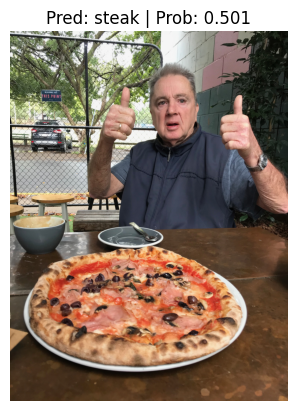

In [71]:
import requests

from going_modular.predictions import pred_and_plot_image

custom_image_path = image_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)